In [1]:
import os
import cmocean
import numpy as np
import xarray as xr
from glob import glob
from scipy import signal
import matplotlib.cm as cm
from itertools import product
import matplotlib.pyplot as plt

from thermal.utils import calc_Temp
from thermal.derived_fields import calc_mean_enthalpy, calc_length, calc_volume
from thermal.plotting import enthalpy_pcolormesh, make_colorbar

plt.rcParams['text.usetex'] = True

def get_ELA_indexes(src): 
    # function to find the indexes of the ELA, as a function of time 
    # Generalized enough to support multiple horizontal indexes being at the ELA
        
    # create a two dimensional 'coord_1' array for boolean masking
    _, coord_1 = xr.broadcast(src.t, src.coord_1)
    
    # the difference of the sign will tell us where the mass balance crosses zero
    mask = xr.apply_ufunc(np.diff, 
                          np.sign(src['mass balance']), 
                          kwargs={"axis": -1, "prepend" : -1},
                          dask="allowed")

    # the difference should be 2 at the ELA, 0 all other places
    ELA_idxs = coord_1.where(mask == 2, drop=False)
    
    # probably need to rename the coordinate. 
    return ELA_idxs


def height_at_ELA(ds, ELA_idxs):
    """ ds -> ice thickness along free surface
    """
    
    # get the indexes as numpy interger array, squeeze the time dimension
    idxs = ELA_idxs.sel(t=ds.t).dropna('ELA_coords').astype(int).squeeze().values
    
    if idxs.size > 1: 
        # if multiple gridcells @ ELA; take the mean
        return ds.sel(coord_1=idxs).mean('coord_1')
    else: 
        # otherwise return single ice-thickness
        return ds.sel(coord_1=idxs)
    
def parse_params(fn): 
    """ Extract beta value and surge period from filepath
    """
    # strip the file extension
    run_name = os.path.basename(fn).split('.zarr')[0]
    # extract the beta value and turn it into float
    beta = float(run_name.split('B')[-1].split('_')[1])
    # extract the surge recurrence, add 2 year surge period to get surge cycle
    SP = float(run_name.split('QP')[-1].split('_')[1]) + 2 
    return np.array([beta, SP])



In [2]:
drive_src = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/'
zarr_path = 'result/crmpt12/gridded/Frictional_heating/crmpt12_dx_50_TT_*--*ka_MB_-0.37_OFF_Tma_-8.5_B_{beta:1.3e}_SP_2_QP_{QP}.zarr'

src_fp = drive_src + zarr_path

In [3]:
_, norm, s_map, bounds = make_colorbar(-np.log(np.logspace(-3, -4, 9)), cmap='magma')
#overwrite the colormap wiht a cmocean colormap
cmap = cmocean.cm.thermal

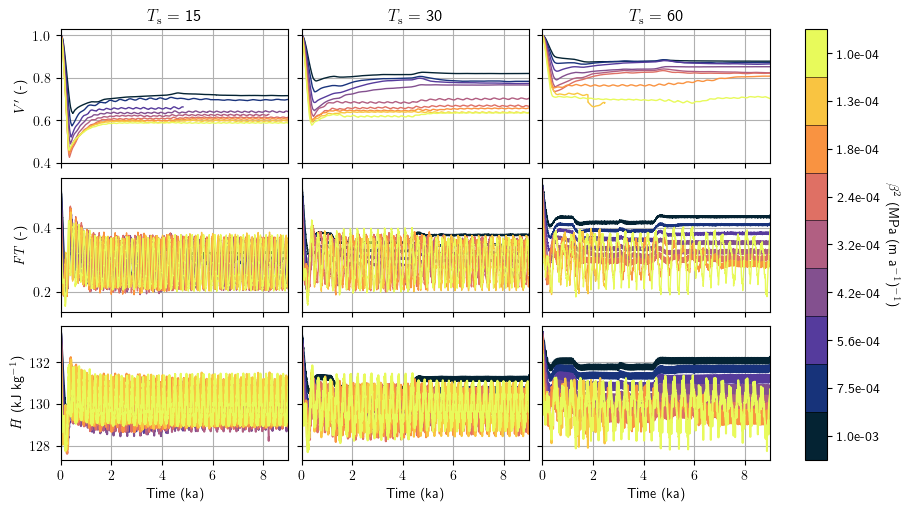

In [4]:
fig, ax = plt.subplots(3,3, sharex=True, sharey='row', 
                       figsize=(9,5), constrained_layout=True)

for i, QP in enumerate([13, 28, 58]): 
    for beta in np.logspace(-3, -4, 9): 
            
        color = cmap(norm(-np.log(beta)))
                
        src = xr.open_mfdataset(src_fp.format(beta=beta, QP=QP), engine='zarr')
        
        # recompute the volume based on the concatenated timeseires
        volume = calc_volume(src)
        # write the initial volume in m^2
        src['initial_volume']  = volume.isel(t=0)
        # write the time dependent "relative volume"
        src['relative_volume'] = volume / volume.isel(t=0)        
            
        # calculate mean enthalpy before smoothing 
        src['mean_enthalpy'] = calc_mean_enthalpy(src)
        
        # downsample the data to annualaal timesteps
        src = src.interp(t=np.linspace(0.1, 9e3, 90_000, endpoint=False),
                         method="linear")
        # Annual rolling window mean 
        src = src.rolling(t=10,center=True, min_periods=1).mean('t')
        
        ax[0,i].plot(src.t/1e3, src.relative_volume, color=color, lw=1.0)
        ax[1,i].plot(src.t/1e3, src.percent_temperate/100, color=color, lw=1.0)
        ax[2,i].plot(src.t/1e3, src.mean_enthalpy/1e3, color=color)
    
    ax[0,i].set_title(r'$T_{\rm s}$ = ' + str(QP+2))
    ax[2,i].set_xlabel('Time (ka)')
    
    for j in range(3): 
        ax[i,j].grid() 
        
ax[0,0].set_xlim(0,9);
ax[0,0].set_ylabel("$V'$ (-)");
ax[1,0].set_ylabel(r"$\mathit{FT}$ (-)");
ax[2,0].set_ylabel(r"$\bar{H}$ (kJ kg$^{-1}$)");

s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
s_map.set_array(-np.log(np.logspace(-3, -4, 9)))
    
cbar = fig.colorbar(s_map, 
                    ax=ax, 
                    norm=norm, 
                    spacing='proportional',
                    ticks=-np.log(np.logspace(-3, -4, 9)), 
                    boundaries=bounds,
                    drawedges=True,
                    )
    
cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', np.logspace(-3, -4, 9)))

cbar.set_label(r"$\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)", rotation=270, labelpad=15)

# fig.savefig('/Users/andrewnolan/Desktop/new_periodic_results_9ka.png', dpi=400)

In [5]:
QP = 28

# for beta in np.logspace(-3, -4, 9): 
            
#         color = cmap(norm(-np.log(beta)))
                
#         src = xr.open_mfdataset(src_fp.format(beta=beta, QP=QP), engine='zarr')
        
#         # recompute the volume based on the concatenated timeseires
#         volume = calc_volume(src)
#         # write the initial volume in m^2
#         src['initial_volume']  = volume.isel(t=0)
#         # write the time dependent "relative volume"
#         src['relative_volume'] = volume / volume.isel(t=0)     

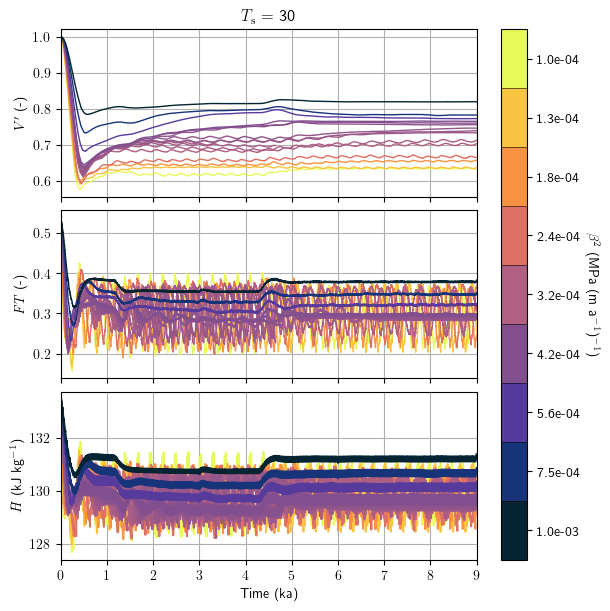

In [6]:
drive_src = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/'
zarr_path = 'result/crmpt12/gridded/Frictional_heating/crmpt12_dx_50_TT_*--*ka_MB_-0.37_OFF_Tma_-8.5_B_{beta}_SP_2_QP_{QP}.zarr'

src_fp = drive_src + zarr_path

files = glob(src_fp.format(beta='*', QP=QP))

QP = 28

# parse the parameter combinations from the file names
params = np.vstack(list(map(parse_params,files)))

betas   = np.unique(params[:,0])

fig, ax = plt.subplots(3,1, sharex=True, sharey='row', 
                       figsize=(6,6), constrained_layout=True)



for beta in betas: 

    color = cmap(norm(-np.log(beta)))

    src = xr.open_mfdataset(src_fp.format(beta=f'{beta:1.3e}', QP=QP), engine='zarr')

    # recompute the volume based on the concatenated timeseires
    volume = calc_volume(src)
    # write the initial volume in m^2
    src['initial_volume']  = volume.isel(t=0)
    # write the time dependent "relative volume"
    src['relative_volume'] = volume / volume.isel(t=0)        

    # calculate mean enthalpy before smoothing 
    src['mean_enthalpy'] = calc_mean_enthalpy(src)

    # downsample the data to annualaal timesteps
    src = src.interp(t=np.linspace(0.1, 9e3, 90_000, endpoint=False),
                     method="linear")
    # Annual rolling window mean 
    src = src.rolling(t=10,center=True, min_periods=1).mean('t')

    ax[0].plot(src.t/1e3, src.relative_volume, color=color, lw=1.0)
    ax[1].plot(src.t/1e3, src.percent_temperate/100, color=color, lw=1.0)
    ax[2].plot(src.t/1e3, src.mean_enthalpy/1e3, color=color)
    
ax[0].set_title(r'$T_{\rm s}$ = ' + str(QP+2))
ax[2].set_xlabel('Time (ka)')
    
for j in range(3): 
    ax[j].grid() 
        
ax[0].set_xlim(0,9);
ax[0].set_ylabel("$V'$ (-)");
ax[1].set_ylabel(r"$\mathit{FT}$ (-)");
ax[2].set_ylabel(r"$\bar{H}$ (kJ kg$^{-1}$)");

s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
s_map.set_array(-np.log(np.logspace(-3, -4, 9)))
    
cbar = fig.colorbar(s_map, 
                    ax=ax, 
                    norm=norm, 
                    spacing='proportional',
                    ticks=-np.log(np.logspace(-3, -4, 9)), 
                    boundaries=bounds,
                    drawedges=True,
                    )
    
cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', np.logspace(-3, -4, 9)))

cbar.set_label(r"$\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)", rotation=270, labelpad=15)

fig.savefig('/Users/andrewnolan/Desktop/bisected_periodic_results_9ka.png', dpi=400)

In [ ]:
SP = 58
beta = 1.778e-4
src = xr.open_mfdataset(src_fp.format(beta=beta, QP=QP), engine='zarr')

# recompute the volume based on the concatenated timeseires
volume = calc_volume(src)
# write the initial volume in m^2
src['initial_volume']  = volume.isel(t=0)
# write the time dependent "relative volume"
src['relative_volume'] = volume / volume.isel(t=0)        

src.percent_temperate.plot()

In [ ]:

drive_src = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/'
zarr_path = 'result/crmpt12/gridded/crmpt12_dx_50_TT_6000.0_MB_-0.37_OFF_Tma_-8.5_B_{beta:1.3e}_SP_2_QP_{QP}.zarr'

src_fp = drive_src + zarr_path
for i, N in enumerate([-2, -1, None]): 
    
    
    fig, ax = plt.subplots(2,1, sharex=True, constrained_layout=True)
    
    for beta in np.logspace(-6, -8, 9)[:N]**0.5: 
            
        color = cmap(norm(-np.log(beta**2)))
        src = xr.open_zarr(src_fp.format(beta=beta, QP=QP))
            
        # downsample the data to annualaal timesteps
        src = src.interp(t=np.linspace(0.0, 6e3, 60_00, endpoint=False),
                         method="linear")
        
        ax[0].plot(src.t/1e3, src.relative_volume, color=color, lw=1.5)
        ax[1].plot(src.t/1e3, src.percent_temperate/100, color=color, lw=1.5)
        
    
    ax[0].grid()
    ax[1].grid()
    
    ax[0].set_ylim(0.65,1.01);
    ax[1].set_ylim(0.175,0.55);

    ax[0].set_title(r'$T_{\rm s}$ = 60')
    ax[1].set_xlabel('Time (ka)')

    ax[0].set_xlim(0,6);
    ax[0].set_ylabel("$V'$ (-)");
    ax[1].set_ylabel(r"$\mathit{FT}$ (-)");
    
    s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
    s_map.set_array(-np.log(np.logspace(-6, -8, 9)))

    cbar = fig.colorbar(s_map, 
                        ax=ax, 
                        norm=norm, 
                        spacing='proportional',
                        ticks=-np.log(np.logspace(-6, -8, 9)), 
                        boundaries=bounds,
                        drawedges=True,
                        )

    cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', np.logspace(-6, -8, 9)))

    cbar.set_label(r"$\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)", rotation=270, labelpad=15)
    
    fig.savefig(f'/Users/andrewnolan/Desktop/periods_{i+1}.png', dpi=400)